<h1><center> Rain in Australia - tomorrow's rain forecast</center></h1>

![RainFall](img\country_road_dirt_road_rural_countryside_clouds_field_landscape_nature-1096294.jpg!d)

image source: https://c.pxhere.com/photos/9d/c3/country_road_dirt_road_rural_countryside_clouds_field_landscape_nature-1096294.jpg!d

### Context

Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow

### Content

This dataset contains daily weather observations from numerous Australian weather stations.

The target variable RainTomorrow means: Did it rain the next day? Yes or No.

Note: You should exclude the variable Risk-MM when training a binary classification model. Not excluding it will leak the answers to your model and reduce its predictability. Read more about it here.



**Dependent**

RainTomorrow: The target variable. Did it rain the following day? YES/NO**

**Independent**

Master
* Date: The date of observation
* Location: The common name of the location of the weather station

Temp
* MinTemp: The minimum temperature in degrees celsius
* MaxTemp: The maximum temperature in degrees celsius

Percipitation
* Rainfall: The amount of rainfall recorded for the day in mm
* Evaporation: The so-called Class A pan evaporation (mm) in the 24 hours to 9am

Sunshine
* Sunshine: The number of hours of bright sunshine in the day.

Wind
* WindGustDir: The direction of the strongest wind gust in the 24 hours to midnight
* WindGustSpeed: The speed (km/h) of the strongest wind gust in the 24 hours to midnight
* WindDir9am: Direction of the wind at 9am
* WindDir3p: Direction of the wind at 3pm
* WindSpeed9am: Wind speed (km/hr) averaged over 10 minutes prior to 9am
* WindSpeed3pm: Wind speed (km/hr) averaged over 10 minutes prior to 3pm

Humidity
* Humidity9a: Humidity (percent) at 9am
* Humidity3pm: Humidity (percent) at 3pm

Pressure
* Pressure9am: Atmospheric pressure (hpa) reduced to mean sea level at 9am
* Pressure3pm: Atmospheric pressure (hpa) reduced to mean sea level at 3pm

Cloud cover
* Cloud9am: Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
* Cloud3pm: Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm. See Cload9am for a description of the values

Temperature
* Temp9am: Temperature (degrees C) at 9am
* Temp3pm: Temperature (degrees C) at 3pm

Today's rain
* RainToday: Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0

To remove
* RISK_MM: The amount of next day rain in mm. Used to create response variable RainTomorrow. A kind of measure of the "risk". Will be left out in the model.


### Source & Acknowledgements

Observations were drawn from numerous weather stations. The daily observations are available from http://www.bom.gov.au/climate/data. Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

Definitions adapted from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml

This dataset is also available via the R package rattle.data and at https://rattle.togaware.com/weatherAUS.csv. Package home page: http://rattle.togaware.com. Data source: http://www.bom.gov.au/climate/dwo/ and http://www.bom.gov.au/climate/data.

And to see some nice examples of how to use this data: https://togaware.com/onepager/


Reference materials to build this notebook:

(1) https://www.kaggle.com/lauriandwu/will-it-rain-tomorrow-eda-classification

(2) https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761

## 1) Load data and packages

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from lightgbm import LGBMClassifier #https://www.kaggle.com/ezietsman/simple-python-lightgbm-example
import time
from datetime import datetime

In [86]:
df_loaded = pd.read_csv(r'DATA\weatherAUS.csv')

In [87]:
df_loaded[['Date','RainToday']].head(17)

,Date,RainToday
0,2008-12-01,No
1,2008-12-02,No
2,2008-12-03,No
3,2008-12-04,No
4,2008-12-05,No
5,2008-12-06,No
6,2008-12-07,No
7,2008-12-08,No
8,2008-12-09,No
9,2008-12-10,Yes


In [88]:
df_raw = df_loaded.copy()

In [89]:
df_raw = df_raw.drop(['RISK_MM'],axis=1)
df_raw = df_raw.sort_values(['Location','Date'])
df_raw = df_raw.set_index(['Date'])
df_raw.index = pd.to_datetime(df_raw.index)
df_raw.head(20)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,
2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,NW,48.0,SW,W,...,92.0,67.0,1017.4,1017.7,NaN,NaN,13.5,14.9,Yes,No
2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,SW,35.0,SSW,SW,...,75.0,52.0,1022.4,1022.6,NaN,NaN,13.7,15.5,No,No
2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,W,20.0,NNE,SW,...,81.0,56.0,1027.8,1026.5,NaN,NaN,9.3,13.9,No,No
2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,NNE,30.0,NNE,NE,...,71.0,46.0,1028.7,1025.6,NaN,NaN,10.2,15.3,No,No
2008-07-06,Adelaide,11.3,15.7,NaN,NaN,1.5,NNW,52.0,NNE,NNW,...,62.0,62.0,1019.5,1016.2,NaN,NaN,13.0,14.4,NaN,Yes
2008-07-07,Adelaide,7.6,11.2,16.2,4.6,1.1,WSW,46.0,WNW,SW,...,83.0,88.0,1015.9,1017.9,NaN,NaN,9.8,9.3,Yes,Yes
2008-07-08,Adelaide,5.3,13.5,17.0,0.6,2.1,SW,43.0,SW,WSW,...,73.0,91.0,1025.8,1025.9,NaN,NaN,10.9,10.8,Yes,Yes
2008-07-09,Adelaide,8.4,14.3,1.8,1.6,0.8,NW,41.0,N,NW,...,90.0,64.0,1025.8,1022.7,NaN,NaN,10.8,13.5,Yes,Yes
2008-07-10,Adelaide,9.5,13.1,9.0,1.2,7.2,WSW,52.0,WSW,SW,...,54.0,66.0,1019.8,1019.6,NaN,NaN,10.9,11.2,Yes,No


In [90]:
df_raw.shape

(142193, 22)

In [91]:
df_raw.isnull().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

Strange that we have missing values for RainToday.

In [92]:
df_raw.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

We will need to encode WindGustFir, WindDir9am, WindDir3pm, RainToday and RainTomorrow.

In [93]:
df_raw.RainTomorrow.value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Imbalanced data. Will need to use stratified sampling in our cross-validation.

## 2) Data Exporation and Transformation

In [94]:
df_raw = df_raw.replace({'RainTomorrow':'Yes','RainToday':'Yes'},1)
df_raw = df_raw.replace({'RainTomorrow':'No','RainToday':'No'},0)

### 2.1 Handle Missing 'RainToday'.

Check for any missing dates in the dataset, by location

In [95]:
count=0
for location in df_raw['Location'].unique():
    temp_df = df_raw[df_raw['Location']==location]
    # https://stackoverflow.com/questions/52044348/check-for-any-missing-dates-in-the-index
    this_len = len(pd.date_range(start = temp_df.index.min(), end = temp_df.index.max()).difference(temp_df.index))
    count+=this_len
    print(location,this_len)
    #print(temp_df.index.min(),temp_df.index.max())

Adelaide 191
Albany 113
Albury 118
AliceSprings 97
BadgerysCreek 170
Ballarat 101
Bendigo 95
Brisbane 121
Cairns 141
Canberra 107
Cobar 110
CoffsHarbour 145
Dartmoor 92
Darwin 89
GoldCoast 149
Hobart 94
Katherine 17
Launceston 101
Melbourne 847
MelbourneAirport 89
Mildura 91
Moree 244
MountGambier 98
MountGinini 222
Newcastle 173
Nhil 9
NorahHead 169
NorfolkIsland 134
Nuriootpa 95
PearceRAAF 336
Penrith 165
Perth 89
PerthAirport 89
Portland 102
Richmond 147
Sale 98
SalmonGums 143
Sydney 96
SydneyAirport 93
Townsville 96
Tuggeranong 131
Uluru 56
WaggaWagga 122
Walpole 279
Watsonia 99
Williamtown 545
Witchcliffe 146
Wollongong 144
Woomera 107


From the above, we see there are gaps in dates ie dates are not continuous. Therefore, need to make sure that that when we shift the RainfallTomorrow, we join based on the dates. Not straightforward because we will need to shift by location.

In [96]:
df_raw[['Location','RainToday','RainTomorrow']][3000:3050]

,Location,RainToday,RainTomorrow
Date,,,
2017-03-27,Adelaide,0.0,0
2017-03-28,Adelaide,0.0,0
2017-03-29,Adelaide,0.0,1
2017-03-30,Adelaide,1.0,0
2017-03-31,Adelaide,0.0,0
2017-04-01,Adelaide,0.0,0
2017-04-02,Adelaide,0.0,0
2017-04-03,Adelaide,0.0,0
2017-04-04,Adelaide,0.0,0


In [97]:
newRainToday = []
for location in df_raw['Location'].unique():
    # need to iterate by location
    temp_df = df_raw[df_raw['Location']==location][['Location','RainToday','RainTomorrow']].copy()
    # for each date in index, pull the next day's rainfall. If next day is not available, this will return NaN
    shifted = pd.DataFrame(temp_df['RainTomorrow'].shift(+1,freq='D'))#.values.tolist()[1:]
    temp_df = temp_df.join(shifted.rename(columns=lambda x: "RainToday_V2"))
    # since we iterate by location, append these values to a list
    newRainToday.extend(list(temp_df["RainToday_V2"]))

# create new column from the new list
df_raw['RainToday_V2'] = newRainToday
# if the new list is not NAN, bring that value in. If NAN, just use what is the current value
# the new list will be NAN if there was a gap in dates such that the next date did not exist
df_raw['RainToday_V3'] = df_raw.apply(lambda row: row['RainToday_V2'] if pd.notnull(row['RainToday_V2']) else row['RainToday'],axis=1)
df_raw = df_raw.drop(['RainToday_V2','RainToday'],axis=1)
df_raw.rename(columns={'RainToday_V3':'RainToday'},inplace=True)

In [98]:
df_raw['RainToday'] = df_raw['RainToday'].astype('float')
df_raw['RainTomorrow'] = df_raw['RainTomorrow'].astype('float')

In [99]:
df_raw.isnull().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainTomorrow         0
RainToday         1406
dtype: int64

In [100]:
df_raw[['Location','RainToday','RainTomorrow']][3000:3050]

,Location,RainToday,RainTomorrow
Date,,,
2017-03-27,Adelaide,0.0,0.0
2017-03-28,Adelaide,0.0,0.0
2017-03-29,Adelaide,0.0,1.0
2017-03-30,Adelaide,1.0,0.0
2017-03-31,Adelaide,0.0,0.0
2017-04-01,Adelaide,0.0,0.0
2017-04-02,Adelaide,0.0,0.0
2017-04-03,Adelaide,0.0,0.0
2017-04-04,Adelaide,0.0,0.0


We've reduced the number of missing values in RainToday.

### 2.2 Create Features For Yesterday

Just to see if factors from two days ago affect tomorrow's rain. In later versions of this notebook, we may also attempt to forecast rainfall for the day after tomorrow ie using lag_1 features only.

In [101]:
cols_to_lag = df_raw.columns.tolist()
cols_to_lag.remove('Location')
cols_to_lag.remove('RainTomorrow')
cols_to_lag

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustDir',
 'WindGustSpeed',
 'WindDir9am',
 'WindDir3pm',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainToday']

In [102]:
for col in cols_to_lag:
    print("Lagging {}...".format(col))
    lagged_feature = []
    for location in df_raw['Location'].unique():
        # need to iterate by location
        temp_df = df_raw[df_raw['Location']==location][[col]].copy()
        # for each date in index, pull the next day's col. If next day is not available, this will return NaN
        shifted = pd.DataFrame(temp_df[col].shift(+1,freq='D'))#.values.tolist()[1:]
        temp_df = temp_df.join(shifted.rename(columns=lambda x: x + "_lag_1"))
        # since we iterate by location, append these values to a list
        lagged_feature.extend(list(temp_df["{}_lag_1".format(col)]))

    # create new column from the new list
    df_raw["{}_lag_1".format(col)] = lagged_feature
    
print("\nDone\n")
df_raw.columns

Lagging MinTemp...
Lagging MaxTemp...
Lagging Rainfall...
Lagging Evaporation...
Lagging Sunshine...
Lagging WindGustDir...
Lagging WindGustSpeed...
Lagging WindDir9am...
Lagging WindDir3pm...
Lagging WindSpeed9am...
Lagging WindSpeed3pm...
Lagging Humidity9am...
Lagging Humidity3pm...
Lagging Pressure9am...
Lagging Pressure3pm...
Lagging Cloud9am...
Lagging Cloud3pm...
Lagging Temp9am...
Lagging Temp3pm...
Lagging RainToday...

Done



Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainTomorrow', 'RainToday', 'MinTemp_lag_1',
       'MaxTemp_lag_1', 'Rainfall_lag_1', 'Evaporation_lag_1',
       'Sunshine_lag_1', 'WindGustDir_lag_1', 'WindGustSpeed_lag_1',
       'WindDir9am_lag_1', 'WindDir3pm_lag_1', 'WindSpeed9am_lag_1',
       'WindSpeed3pm_lag_1', 'Humidity9am_lag_1', 'Humidity3pm_lag_1',
       'Pressure9am_lag_1', 'Pressure3pm_lag_1', 'Cloud9am_lag_1',
       'Cloud3pm_lag_1', 'Temp9am_lag_1', 'Temp3pm_lag_1', 'RainToday_lag_1'],
      dtype='object')

In [103]:
df_raw[['Location','RainToday','RainTomorrow','RainToday_lag_1']][3000:3050]

,Location,RainToday,RainTomorrow,RainToday_lag_1
Date,,,,
2017-03-27,Adelaide,0.0,0.0,0.0
2017-03-28,Adelaide,0.0,0.0,0.0
2017-03-29,Adelaide,0.0,1.0,0.0
2017-03-30,Adelaide,1.0,0.0,0.0
2017-03-31,Adelaide,0.0,0.0,1.0
2017-04-01,Adelaide,0.0,0.0,0.0
2017-04-02,Adelaide,0.0,0.0,0.0
2017-04-03,Adelaide,0.0,0.0,0.0
2017-04-04,Adelaide,0.0,0.0,0.0


### 2.3 Data distributions

In [104]:
df_raw.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindSpeed3pm_lag_1,Humidity9am_lag_1,Humidity3pm_lag_1,Pressure9am_lag_1,Pressure3pm_lag_1,Cloud9am_lag_1,Cloud3pm_lag_1,Temp9am_lag_1,Temp3pm_lag_1,RainToday_lag_1
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,...,138045.000000,138891.000000,137082.000000,126815.000000,126848.000000,87718.000000,84324.000000,139753.000000,137958.000000,139282.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,...,18.631968,68.829168,51.454356,1017.655862,1015.259961,4.435008,4.499739,16.984508,21.688781,0.222979
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,...,8.799852,19.065800,20.800702,7.108082,7.038266,2.887521,2.721041,6.492341,6.935130,0.416246
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,...,13.000000,57.000000,37.000000,1013.000000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,...,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,...,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,...,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


We see quite a wide range of scales for features. We will perform feature scaling to handle this.

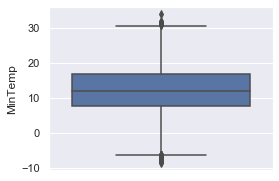

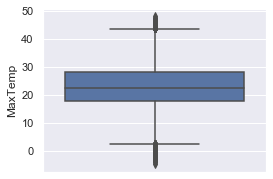

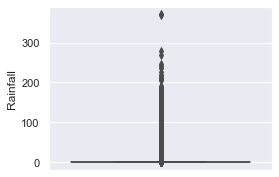

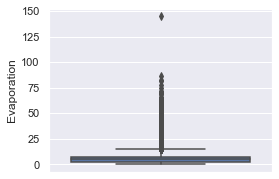

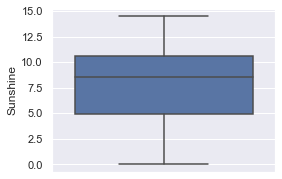

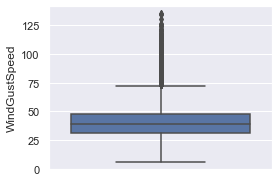

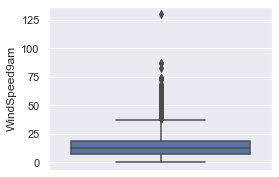

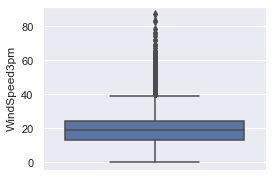

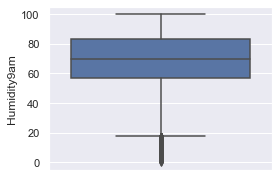

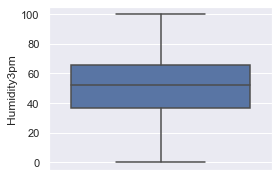

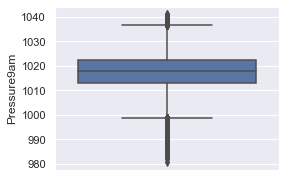

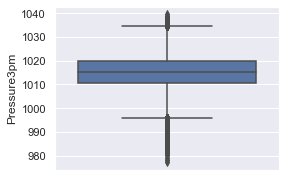

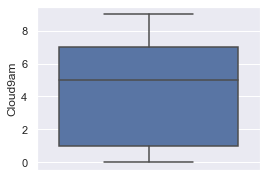

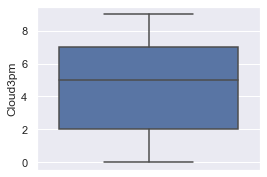

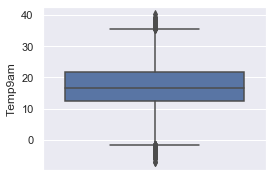

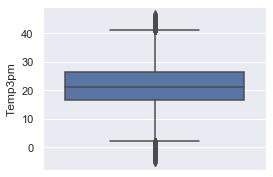

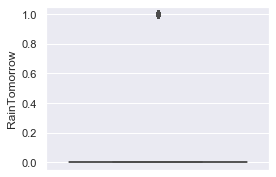

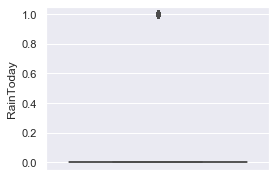

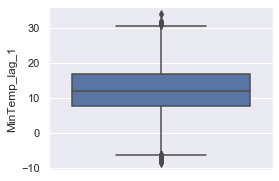

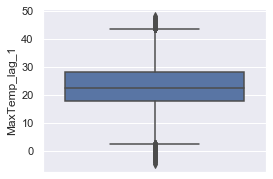

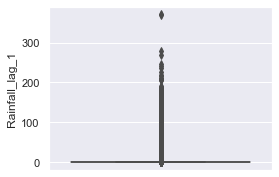

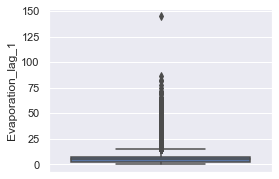

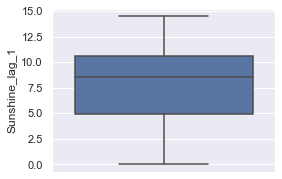

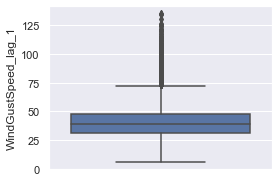

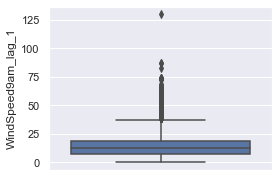

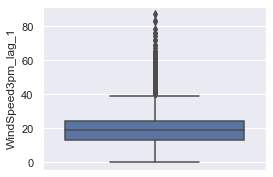

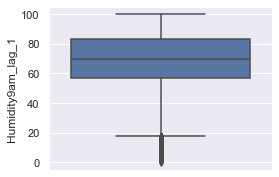

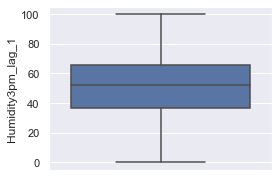

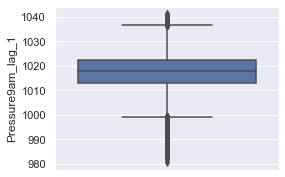

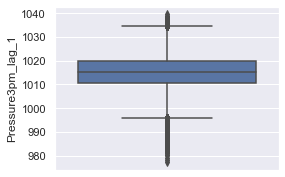

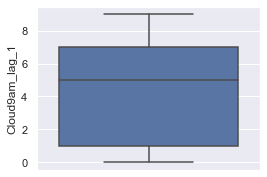

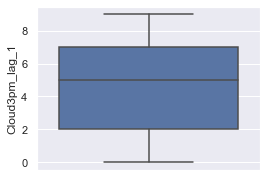

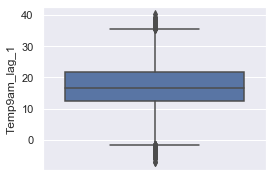

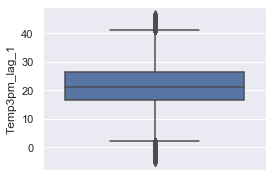

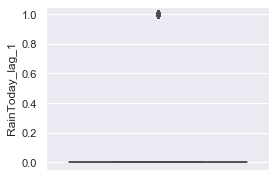

In [105]:
# use seaborn to preserve memory. Standard matplotlib.pyplot consumes alot of memory.
sns.set(rc={'figure.figsize':(4,3)})
for column in df_raw.columns:
    if df_raw[column].dtype != 'object':
        sns.boxplot(y=df_raw[column])
        plt.show()


We see some cases of outliers. Given that some of the models we will use later perform better with data is close to normal , we will use a Standard Scaler. 

### 2.4 Correlations

**2.4.1 Correlation plot**

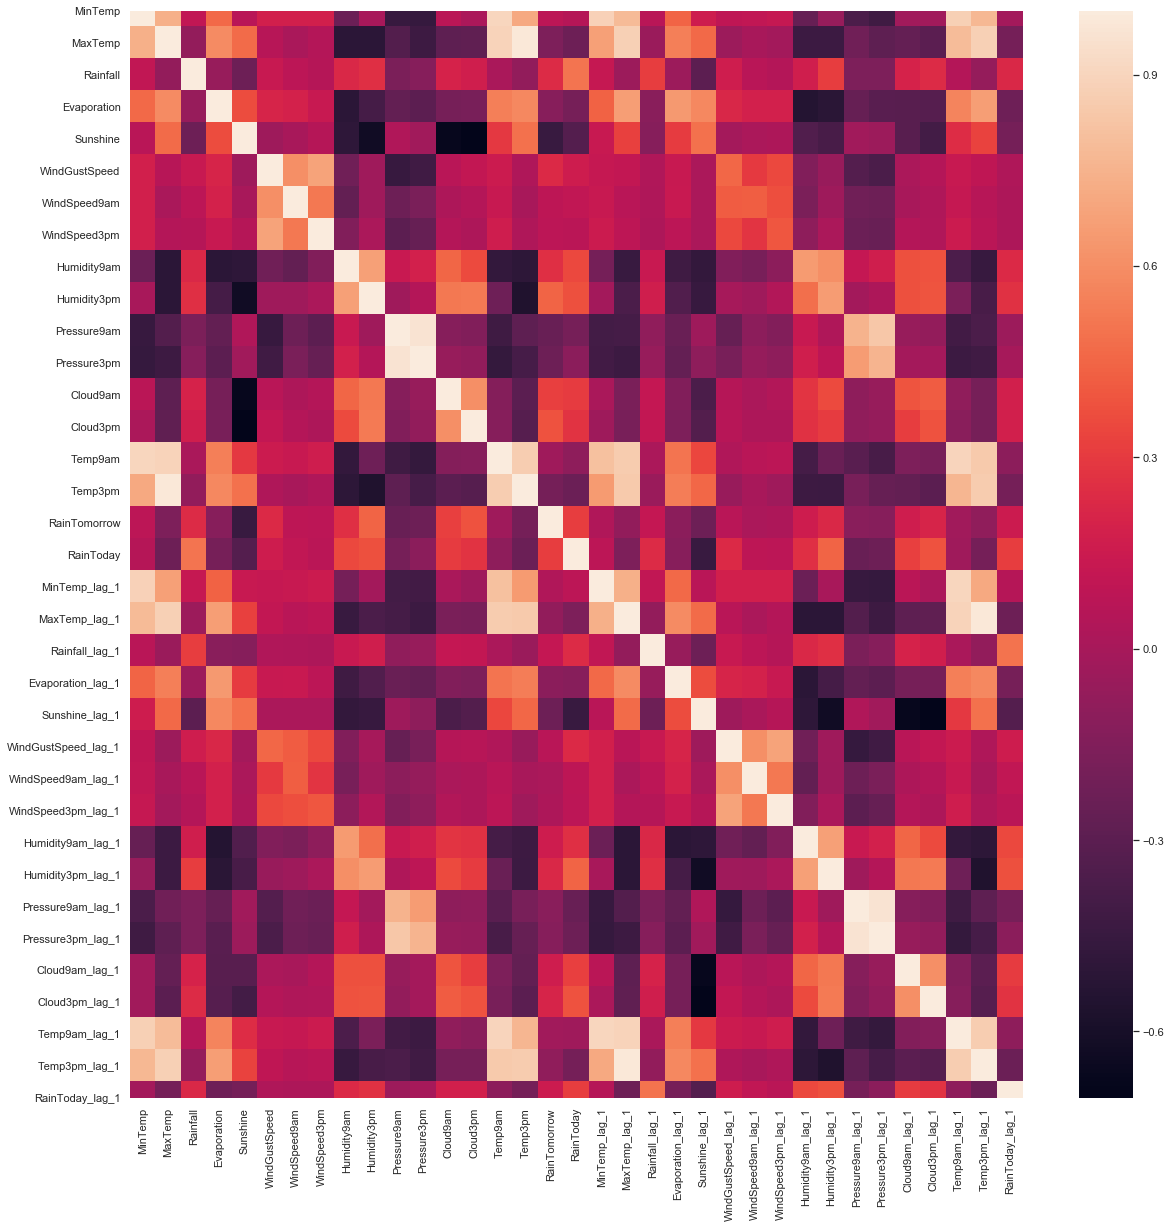

In [106]:
plt.figure(figsize=(20,20))
sns.heatmap(df_raw.corr())

From the correlation plot above, we see some features that appear to have a corr with rainfall tomorrow. We explore some of them next.

**2.4.2 Sunshine**

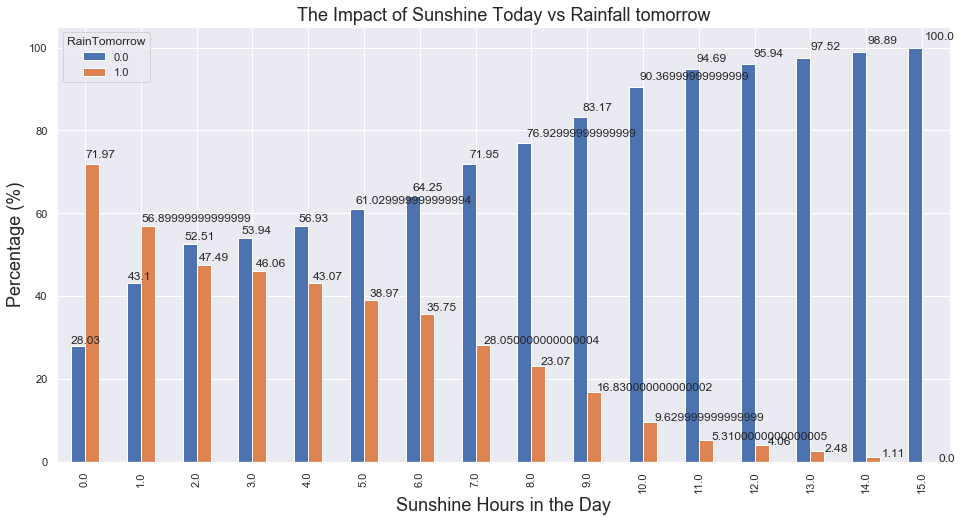

In [107]:
temp_df = df_raw[['Sunshine','RainTomorrow']].copy()
temp_df.Sunshine = np.ceil(temp_df.Sunshine)

yes_no_by_sunshine = pd.crosstab(temp_df['Sunshine'], temp_df['RainTomorrow']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)

sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_sunshine.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Sunshine Today vs Rainfall tomorrow", fontsize=18)
plt.xlabel("Sunshine Hours in the Day", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

plt.show()

From the above, very clear that the higher the number of sunshine hours today, the less likely there will be rain tomorrow.

**2.4.3 Sunshine_lag_1**

ie yesterday's sunshine. Note, yesterday's sunshine also correlates with today's sunshine. Therefore, likely to be a case of multicollinearity. 

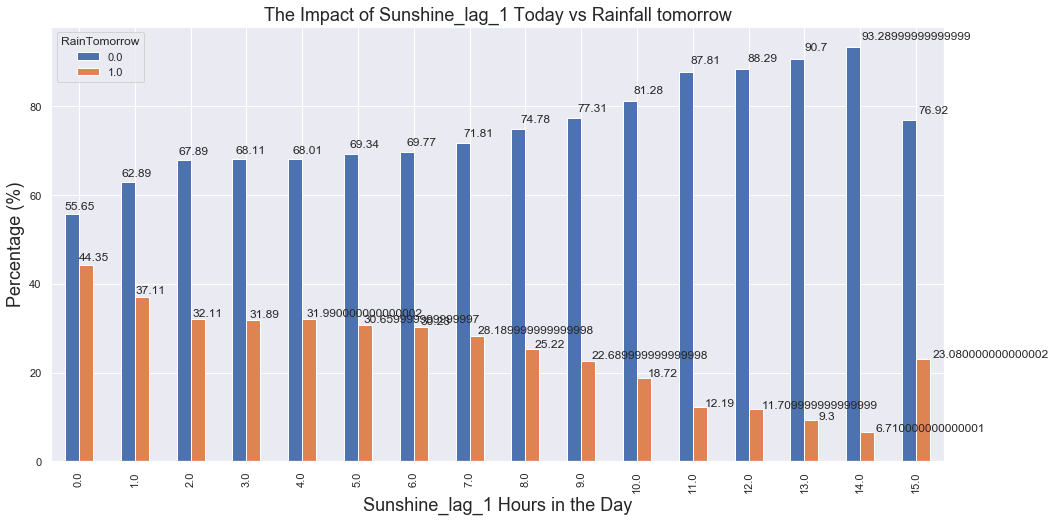

In [108]:
temp_df = df_raw[['Sunshine_lag_1','RainTomorrow']].copy()
temp_df.Sunshine_lag_1 = np.ceil(temp_df.Sunshine_lag_1)

yes_no_by_sunshine = pd.crosstab(temp_df['Sunshine_lag_1'], temp_df['RainTomorrow']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)

sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_sunshine.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Sunshine_lag_1 Today vs Rainfall tomorrow", fontsize=18)
plt.xlabel("Sunshine_lag_1 Hours in the Day", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

plt.show()

Compared to today's sunshine, even at low sunshine_lag_1 hours, not clear evidence to suggest it rains. Therefore, I would say yesterday's sunshine isn't a good predictor of tomorrow's rainfall. However, as shown below, yesterday's sunshine is a potential indicator of today's sunshine so we could potentially use yesterday's sunshine if we were blind about today's sunshine hours.

In [109]:
df_raw[['Sunshine_lag_1','Sunshine']].corr()

,Sunshine_lag_1,Sunshine
Sunshine_lag_1,1.000000,0.491267
Sunshine,0.491267,1.000000


**2.4.4 Pressure 9am and 3pm**

These two variables have some correlation with rain tomorrow. These two variables have high correlations with each other. We can look at either one of these. Seems to

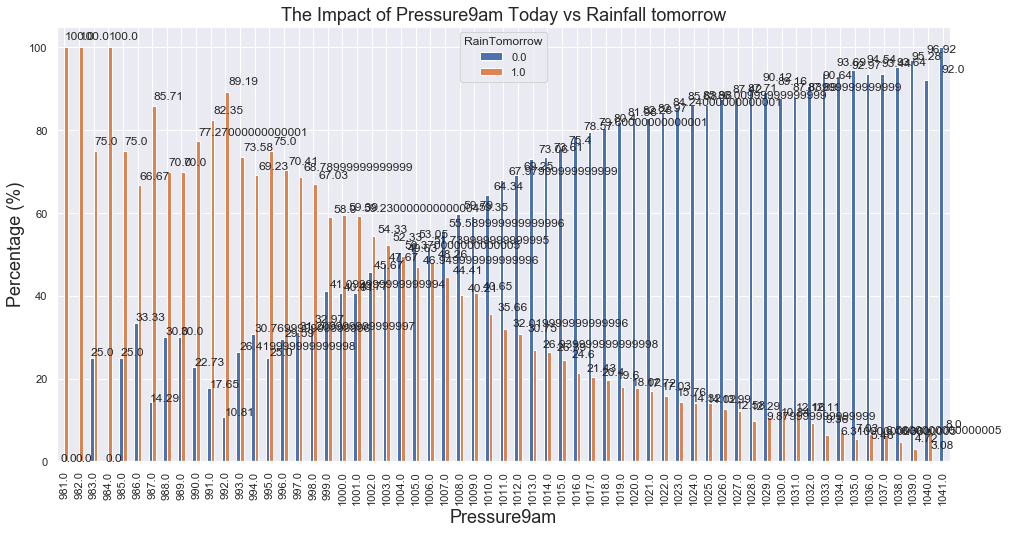

In [110]:
temp_df = df_raw[['Pressure9am','RainTomorrow']].copy()
temp_df.Pressure9am = np.ceil(temp_df.Pressure9am)

yes_no_by_sunshine = pd.crosstab(temp_df['Pressure9am'], temp_df['RainTomorrow']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)

sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_sunshine.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Pressure9am Today vs Rainfall tomorrow", fontsize=18)
plt.xlabel("Pressure9am", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

plt.show()

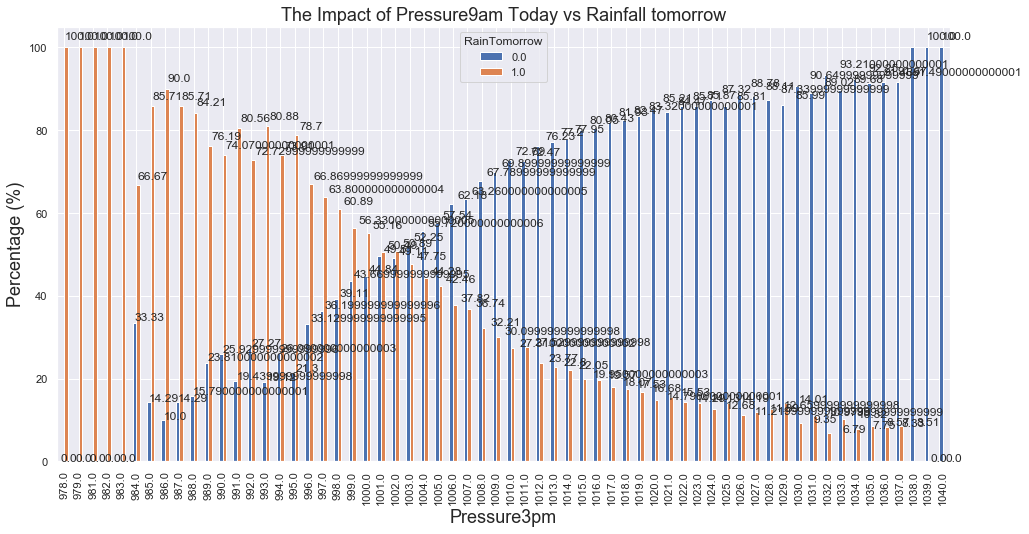

In [111]:
temp_df = df_raw[['Pressure3pm','RainTomorrow']].copy()
temp_df.Pressure3pm = np.ceil(temp_df.Pressure3pm)

yes_no_by_sunshine = pd.crosstab(temp_df['Pressure3pm'], temp_df['RainTomorrow']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)

sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_sunshine.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Pressure9am Today vs Rainfall tomorrow", fontsize=18)
plt.xlabel("Pressure3pm", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

plt.show()

In [112]:
df_raw[['Pressure9am','Pressure3pm']].corr()

,Pressure9am,Pressure3pm
Pressure9am,1.000000,0.961348
Pressure3pm,0.961348,1.000000


From the above, the higher the pressure today during the day, the less likely it rains tomorrow. Note as well the corr between the two variables. 

**2.4.5 Temp3pm**

These two variables have some correlation with rain tomorrow. These two variables have high correlations with each other. We can look at either one of these. Seems to

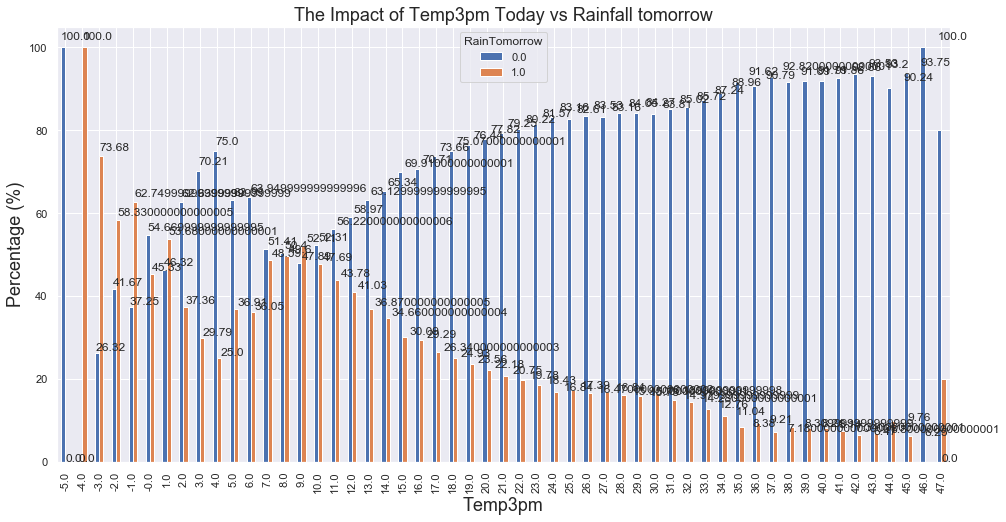

In [113]:
temp_df = df_raw[['Temp3pm','RainTomorrow']].copy()
temp_df.Temp3pm = np.ceil(temp_df.Temp3pm)

yes_no_by_sunshine = pd.crosstab(temp_df['Temp3pm'], temp_df['RainTomorrow']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)

sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_sunshine.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of Temp3pm Today vs Rainfall tomorrow", fontsize=18)
plt.xlabel("Temp3pm", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

plt.show()

The higher the temperature in the afternoon today, the less likely it is to rain tomorrow. But this does not hold true always. What this could imply is that in very cold climates, less likely to rain but once it reaches a certain threshold around 1 degree celsius, more likely to rain than not.

**2.4.5 MaxTemp**

These two variables have some correlation with rain tomorrow. These two variables have high correlations with each other. We can look at either one of these. Seems to

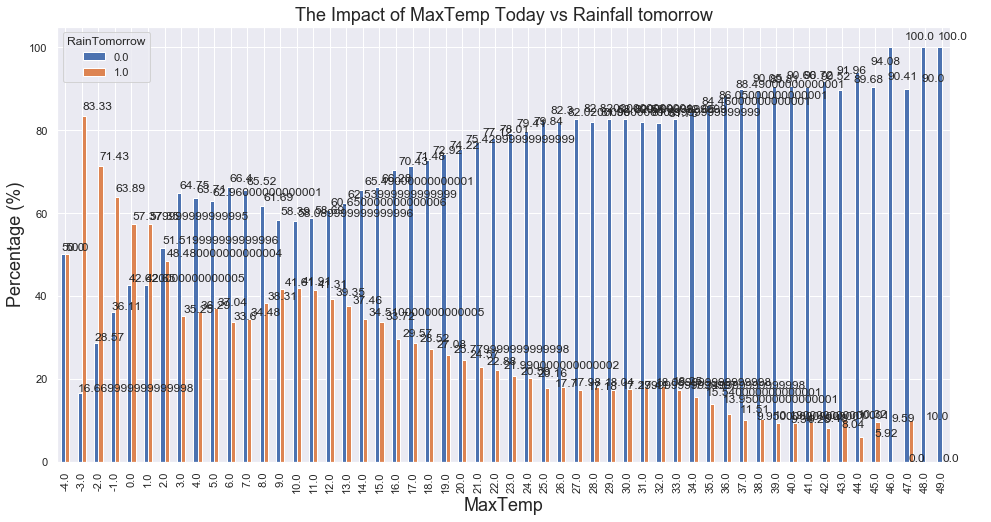

In [114]:
temp_df = df_raw[['MaxTemp','RainTomorrow']].copy()
temp_df.MaxTemp = np.ceil(temp_df.MaxTemp)

yes_no_by_sunshine = pd.crosstab(temp_df['MaxTemp'], temp_df['RainTomorrow']).apply(lambda row: round(row/row.sum(),4) * 100, axis=1)

sns.set(rc={'figure.figsize':(16,8)})
ax = yes_no_by_sunshine.plot(kind='bar', stacked=False)#, order=['0m','1m','2m', '3m', '6m','12m', '24m', '>24m'])
plt.title("The Impact of MaxTemp Today vs Rainfall tomorrow", fontsize=18)
plt.xlabel("MaxTemp", fontsize=18);
plt.ylabel("Percentage (%)", fontsize=18)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.02, p.get_height() * 1.02))

plt.show()

Similar observation as above.

**2.4.6 P-values using GLM**

In [115]:
model = sm.GLM.from_formula("RainTomorrow ~ RainToday + Sunshine + Sunshine_lag_1 + Pressure9am + Pressure3pm + Temp3pm + MaxTemp", family=sm.families.Binomial(), data=df_raw)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           RainTomorrow   No. Observations:                72285
Model:                            GLM   Df Residuals:                    72277
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27011.
Date:                Sun, 26 Jan 2020   Deviance:                       54023.
Time:                        11:50:57   Pearson chi2:                 6.70e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        102.7318      1.850     55.543      0.000      99.107     106.357
RainToday          1.0945      0.026     41.368      0.000       1.043       1.146
Sunshine          -0.2751      0.003    -79.849      0.000      -0.282      -0.268
Sunshine_lag_1     0.0208      0.004      5.925      0.000       0.014       0.028
Pressure9am        0.0935      0.006     15.889      0.000       0.082       0.105
Pressure3pm       -0.1943      0.006    -31.856      0.000      -0.206      -0.182
Temp3pm           -0.2882      0.009    -33.318      0.000      -0.305      -0.271
MaxTemp            0.2387      0.008     28.463      0.000       0.222       0.255
==================================================================================
"""

From the above, all these variables appear to be significant. however, given that we see some multicollinearity between sunshine and sunshine_lag_1, Pressure9am and Pressue3pm, and also between Temp3pm and MaxTemp, we will not necessarily be able to rely on these as the SE are likely underestimated. Nonetheless, the coefficients can be useful. Overall, the more sunshine hours, the hotter it is and the higher the pressure today, the less likely it rains tomorrow. 

We will carve out important features using sklearn once we perform some feature scaling.

## 3) Model development - Predict based on today's info

In this stage, we we attempt to predict rain tomorrrow based on the assumption that today's info is ready. Ie assuming a a live production scenario where we call this info from an API, and that all of the info for today is available at the time of when we need to make a forecast. 

In actual settings, this may not entirely be true. Today's info may only be available tomorrow. Alternatively, one could also imagine a scenario where we need to forecast two days ahead. Ie rain the day after. We may attempt this horizon of forecast in a later versions of the notebook. In this section, we focus on predicting one day ahead.

In [116]:
#df_todays = df_raw[~df_raw.isnull().any(axis=1)].copy()
df_todays = df_raw.copy()
df_todays = df_todays.reset_index()
# do not include lagging features
df_todays = df_todays[[ 'Location','MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday','RainTomorrow']]

# get numeric columns
numeric_cols = df_todays.select_dtypes(include=np.number).columns.tolist()

# encode categorical
# https://stackoverflow.com/questions/48090658/sklearn-how-to-incorporate-missing-data-when-one-hot-encoding
# use pandas instead of sklearn since we have NaNs
df_todays = pd.get_dummies(df_todays)

# create list of categorical features
categoric_cols = [col for col in df_todays.columns if not col in numeric_cols]
# remove target variable, to ensure that we end up with feature set, not label

numeric_cols.remove('RainTomorrow')

feature_names = numeric_cols.copy()
feature_names.extend([col for col in categoric_cols])

len(df_todays)

142193

### 3.1 Split train-validation-test

In [180]:
from sklearn.model_selection import StratifiedShuffleSplit

stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for training_data_indexes, test_data_indexes in stratifier.split(df_todays,df_todays.RainTomorrow):
    stratified_training_data = df_todays.loc[training_data_indexes]
    stratified_test_data = df_todays.loc[test_data_indexes]
    
    
#create copies
train = stratified_training_data.copy()
test = stratified_test_data.copy()

In [181]:
# repeat to split train into train and validation

stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for training_data_indexes, validation_data_indexes in stratifier.split(train,train.RainTomorrow):
    stratified_training_data = train.loc[training_data_indexes]
    stratified_validation_data = train.loc[validation_data_indexes]
    
#create copies
train = stratified_training_data.copy()
validation = stratified_validation_data.copy()    

C:\Users\rianashwin\AppData\Local\Continuum\Anaconda3\envs\ausrain\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
C:\Users\rianashwin\AppData\Local\Continuum\Anaconda3\envs\ausrain\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


In [182]:
train.fillna(train.median(), inplace=True)
test.fillna(train.median(), inplace=True)
validation.fillna(train.median(), inplace=True)

In [183]:
print(len(df_todays),len(train)+len(test)+len(validation))

142193 142193


### 3.2 Feature scaling and union

In [184]:
# build pipeline

from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline

# Making pipelines
numerical_pipeline = Pipeline([
    ("select_numeric", DataFrameSelector(numeric_cols)),
    ("std_scaler", MinMaxScaler()),
])

categorical_pipeline = Pipeline([
    ("select_cat", DataFrameSelector(categoric_cols)),
])

from sklearn.pipeline import FeatureUnion
# https://stackoverflow.com/a/52666039
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", numerical_pipeline),
        ("categorical_pipeline", categorical_pipeline),
    ])

# results in array with numeric columns followed by categorical columns

In [185]:
X_train = preprocess_pipeline.fit_transform(train)
X_train

array([[0.51980198, 0.65067179, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4480198 , 0.41266795, 0.006469  , ..., 0.        , 1.        ,
        0.        ],
       [0.4009901 , 0.52591171, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.51732673, 0.44145873, 0.09380054, ..., 0.        , 0.        ,
        0.        ],
       [0.3539604 , 0.42034549, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.69554455, 0.69673704, 0.02749326, ..., 1.        , 0.        ,
        0.        ]])

In [186]:
# do not fit the scaler to validation features
X_validation = preprocess_pipeline.transform(validation)
X_validation

array([[0.39356436, 0.34357006, 0.00215633, ..., 0.        , 0.        ,
        1.        ],
       [0.53465347, 0.47024952, 0.00808625, ..., 0.        , 0.        ,
        0.        ],
       [0.76980198, 0.69673704, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.76732673, 0.76583493, 0.00269542, ..., 0.        , 0.        ,
        0.        ],
       [0.37128713, 0.67178503, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.4049904 , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [187]:
# do not fit the scaler to test features
X_test = preprocess_pipeline.transform(test)
X_test

array([[3.91089109e-01, 4.66410749e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.62871287e-01, 3.64683301e-01, 1.07816712e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.28712871e-01, 4.95201536e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [8.06930693e-01, 8.33013436e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.57920792e-01, 5.18234165e-01, 5.39083558e-04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.52475248e-01, 4.41458733e-01, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

### 3.3 Label encoding

In [188]:
#instantiatie label from stratified datasets
y_train = train['RainTomorrow']
y_validation = validation['RainTomorrow']
y_test = test['RainTomorrow']

# encode label
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()
y_train = encode.fit_transform(y_train)
y_validation = encode.fit_transform(y_validation)
y_test = encode.fit_transform(y_test)

### 3.4 Feature selection

https://www.kaggle.com/jepsds/feature-selection-using-selectkbest?utm_campaign=News&utm_medium=Community&utm_source=DataCamp.com

In previous versions, we noticed that the training time can take a while. Therefore, let's see if we can narrow down to just half the features. We will also perform cross-val on the original dataset.

In [189]:
# #uncomment the next two if we want to include test set in Chi2 test
# X_full = np.concatenate((X_train,X_test))
# y_full = np.concatenate((y_train,y_test))
temp_df_X = pd.DataFrame(X_train,columns=feature_names) 
temp_df_y = pd.DataFrame(y_train,columns=['RainTomorrow'])

numfeat = 57

selector = SelectKBest(chi2, k=numfeat)
selector.fit(temp_df_X, temp_df_y)

X_train_min = selector.transform(temp_df_X) # pass to new array
most_important_features = temp_df_X.columns[selector.get_support(indices=True)].tolist()
print("The {} most important features are:".format(numfeat), most_important_features)
print("New dims of X_train: ", X_train.shape)

del temp_df_X, temp_df_y

The 57 most important features are: ['MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'Location_Albany', 'Location_AliceSprings', 'Location_Cairns', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_Melbourne', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Portland', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Uluru', 'Location_Walpole', 'WindGustDir_E', 'WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindDir9am_E', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NNE', 'WindDir3pm_

In [190]:
# retain features in test and validation set as well
temp_df_X = pd.DataFrame(X_validation,columns=feature_names) 
X_validation_min = selector.transform(temp_df_X)
print("New dims of X_test: ", X_validation.shape)

temp_df_X = pd.DataFrame(X_test,columns=feature_names) 
X_test_min = selector.transform(temp_df_X)
print("New dims of X_test: ", X_test.shape)

New dims of X_test:  (12798, 114)
New dims of X_test:  (14220, 114)


**Check memory usage**

https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761. We see that reducting feature size by half reduces memory usage by 50%.

In [191]:
for this_array, this_name in zip([X_train, X_train_min, X_validation, X_validation_min, X_test, X_test_min, y_train, y_test],['X_train', 'X_train_min', 'X_validation', 'X_validation_min', 'X_test', 'X_test_min', 'y_train', 'y_test']):
    temp_df= pd.DataFrame(this_array)
    this_memory = temp_df.memory_usage().sum() / 1024**2
    print("Memory usage of {} is {:.2f} MB\n".format(this_name,this_memory))

Memory usage of X_train is 100.17 MB

Memory usage of X_train_min is 50.09 MB

Memory usage of X_validation is 11.13 MB

Memory usage of X_validation_min is 5.57 MB

Memory usage of X_test is 12.37 MB

Memory usage of X_test_min is 6.18 MB

Memory usage of y_train is 0.88 MB

Memory usage of y_test is 0.11 MB



### 3.5 First pass of cross-val

As this is a classification problem, we will focus on precision and recall, and loop through both datasets (min and full features) and see the performance and time difference in training on the two different feature sets.

***Note: Time here is measured in seconds***

In [192]:
dict_classifiers = {
    'logistic_reg': LogisticRegression(max_iter=400), #default is 100 but we were hitting ConvergenceWarning
    'xgboost_clf': XGBClassifier(),
    'lightgbm_clf': LGBMClassifier()
}

dict_preds = {}
dict_preds_min = {}

for Xs_array, Xs_name in zip([X_train,X_train_min],['X_train','X_train_min']):
    print("\n{}".format(Xs_name))
    for this_classifier in dict_classifiers.keys():
        t0=time.time()
        this_score = cross_val_score(dict_classifiers[this_classifier], Xs_array, y_train, cv=5)
        # https://stackoverflow.com/questions/25006369/what-is-sklearn-cross-validation-cross-val-score
        this_mean = this_score.mean()
        # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
        if Xs_name == 'X_train':
            dict_preds[this_classifier] = cross_val_predict(dict_classifiers[this_classifier], X_train, y_train, cv=5) #get predictions, for ROC curve
        else:
            dict_preds_min[this_classifier] = cross_val_predict(dict_classifiers[this_classifier], X_train, y_train, cv=5)
            
        print("\n",this_classifier, this_mean)
        print('Time taken to execute (seconds):' , time.time()-t0)


X_train

 logistic_reg 0.8628434990232255
Time taken to execute (seconds): 32.90772843360901

 xgboost_clf 0.8633557629693944
Time taken to execute (seconds): 236.06551027297974

 lightgbm_clf 0.8713262426741915
Time taken to execute (seconds): 19.44573974609375

X_train_min

 logistic_reg 0.8596830909485564
Time taken to execute (seconds): 26.33529233932495

 xgboost_clf 0.8628000868243977
Time taken to execute (seconds): 173.8128252029419

 lightgbm_clf 0.868869112220534
Time taken to execute (seconds): 14.311584234237671


LightGBM is clearly the fastest and on default parameters has the highest accuracy. Given the minimal time difference for LightGBM between the full training set and the reduced training set, and that the model does better on the full training set, we will go ahead and use LightGBM with the full training set.

(GradientBoostingClassifier() takes the longest time to train as expected therefore not included in this notebook)



**Evaluate confusion matrix, and precision and recall**

Plot confusion matrix to see precision and recall. Note the following:

- TN: We forecasted no rain tomorrow, and in reality did not
- TP: We forecasted rain tomorrow, and in reality did
- FN: We forecasted no rain tomorrow, but in reality did
- FP: We forecasted rain tomorrow, but in reality did not

(top row) true positive, false positive

(bottom row) false negative, true negative

In [193]:
from sklearn.metrics import confusion_matrix
#https://machinelearningmastery.com/confusion-matrix-machine-learning/


for this_classifier in dict_preds.keys():
    this_pred = dict_preds[this_classifier]
    confusion_results = confusion_matrix(y_train, this_pred)
    print("\n\n\n", this_classifier)
    print("\nFull training set\n")
    print(confusion_results)
#     this_pred_min = dict_preds_min[this_classifier]
#     confusion_results_min = confusion_matrix(y_train, this_pred_min)
#     print("\nReduced training set\n")
#     print(confusion_results_min)




 logistic_reg

Full training set

[[87593  4362]
 [11435 11785]]



 xgboost_clf

Full training set

[[88057  3898]
 [11840 11380]]



 lightgbm_clf

Full training set

[[87840  4115]
 [10705 12515]]


In [194]:
from sklearn.metrics import classification_report
#https://machinelearningmastery.com/confusion-matrix-machine-learning/
 
for this_classifier in dict_preds.keys():
    this_pred = dict_preds[this_classifier]
    classification_results = classification_report(y_train, this_pred, labels=[0, 1])
    print("\n\n\n", this_classifier)
    print("\nFull training set\n")
    print(classification_results)
#     this_pred_min = dict_preds_min[this_classifier]
#     classification_results_min = classification_report(y_train, this_pred_min, labels=[0, 1])    
#     print("\nReduced training set\n")
#     print(classification_results_min)    




 logistic_reg

Full training set

              precision    recall  f1-score   support

           0       0.88      0.95      0.92     91955
           1       0.73      0.51      0.60     23220

    accuracy                           0.86    115175
   macro avg       0.81      0.73      0.76    115175
weighted avg       0.85      0.86      0.85    115175




 xgboost_clf

Full training set

              precision    recall  f1-score   support

           0       0.88      0.96      0.92     91955
           1       0.74      0.49      0.59     23220

    accuracy                           0.86    115175
   macro avg       0.81      0.72      0.75    115175
weighted avg       0.85      0.86      0.85    115175




 lightgbm_clf

Full training set

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     91955
           1       0.75      0.54      0.63     23220

    accuracy                           0.87    115175
   macro avg      

### 3.6 Tune hyperparameters for LightGBM

https://www.kaggle.com/mlisovyi/lightgbm-hyperparameter-optimisation-lb-0-761. Use this notebook as reference given limited examples online for hp tuning.

In [195]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [197]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100 #therefore, since we choose 100 diff combos of HP and cv 3 times, we therefore are doing 300 folds

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_validation, y_validation)], # use validation set as eval_set to avoid overfitting
            'eval_names': ['validation set'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.89904
[200]	validation set's auc: 0.903025
[300]	validation set's auc: 0.904586
Early stopping, best iteration is:
[330]	validation set's auc: 0.904837
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.898222
[200]	validation set's auc: 0.902083
[300]	validation set's auc: 0.903337
[400]	validation set's auc: 0.904028
[500]	validation set's auc: 0.904336
Early stopping, best iteration is:
[536]	validation set's auc: 0.904414
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.898432
[200]	validation set's auc: 0.90225
[300]	validation set's auc: 0.903507
[400]	validation set's auc: 0.903998
Early stopping, best iteration is:
[412]	validation set's auc: 0.904134
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899281
[200]	validation set's auc: 0.902608
[300]	validation set's a

[400]	validation set's auc: 0.903663
Early stopping, best iteration is:
[420]	validation set's auc: 0.903865
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.900005
[200]	validation set's auc: 0.90325
Early stopping, best iteration is:
[265]	validation set's auc: 0.903528
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899027
[200]	validation set's auc: 0.902229
[300]	validation set's auc: 0.902852
[400]	validation set's auc: 0.903031
Early stopping, best iteration is:
[383]	validation set's auc: 0.903182
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.898737
[200]	validation set's auc: 0.902225
[300]	validation set's auc: 0.902801
Early stopping, best iteration is:
[303]	validation set's auc: 0.902829
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.900163
[200]	validation set's auc: 0.903577
Early stopping, best iter

[200]	validation set's auc: 0.904638
[300]	validation set's auc: 0.905125
[400]	validation set's auc: 0.905446
Early stopping, best iteration is:
[399]	validation set's auc: 0.90547
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.90085
[200]	validation set's auc: 0.903199
[300]	validation set's auc: 0.904067
Early stopping, best iteration is:
[311]	validation set's auc: 0.904216
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.885631
Early stopping, best iteration is:
[149]	validation set's auc: 0.887516
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.885193
[200]	validation set's auc: 0.886716
Early stopping, best iteration is:
[205]	validation set's auc: 0.886716
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.885946
Early stopping, best iteration is:
[153]	validation set's auc: 0.887657
Training until validation sc

Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.890335
[200]	validation set's auc: 0.894147
[300]	validation set's auc: 0.89486
Early stopping, best iteration is:
[298]	validation set's auc: 0.89486
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.890608
[200]	validation set's auc: 0.894215
[300]	validation set's auc: 0.894875
Early stopping, best iteration is:
[289]	validation set's auc: 0.894875
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.888008
Early stopping, best iteration is:
[111]	validation set's auc: 0.888177
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.887938
Early stopping, best iteration is:
[120]	validation set's auc: 0.88833
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.888663
Early stopping, best iteration is:
[115]	validation set's auc: 0.888914
Train

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	validation set's auc: 0.5
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[1]	validation set's auc: 0.5
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.886821
Early stopping, best iteration is:
[143]	validation set's auc: 0.88776
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.886185
Early stopping, best iteration is:
[130]	validation set's auc: 0.886795
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.887211
Early stopping, best iteration is:
[132]	validation set's auc: 0.887923
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.902151
[200]	validation set's auc: 0.903736
Early stopping, best iteration is:
[205]	validation set's auc: 0.903865
Training until validation scores

Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.900328
[200]	validation set's auc: 0.903525
[300]	validation set's auc: 0.904247
Early stopping, best iteration is:
[338]	validation set's auc: 0.904451
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899256
[200]	validation set's auc: 0.902529
[300]	validation set's auc: 0.903141
Early stopping, best iteration is:
[331]	validation set's auc: 0.903184
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899767
[200]	validation set's auc: 0.903156
[300]	validation set's auc: 0.903624
Early stopping, best iteration is:
[305]	validation set's auc: 0.903727
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.891827
[200]	validation set's auc: 0.895393
Early stopping, best iteration is:
[210]	validation set's auc: 0.895602
Training until validation scores don't improve for 30 rounds


[300]	validation set's auc: 0.901851
[400]	validation set's auc: 0.9028
[500]	validation set's auc: 0.903161
[600]	validation set's auc: 0.903444
Early stopping, best iteration is:
[632]	validation set's auc: 0.903529
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.893734
[200]	validation set's auc: 0.898868
[300]	validation set's auc: 0.90082
[400]	validation set's auc: 0.901721
[500]	validation set's auc: 0.902079
Early stopping, best iteration is:
[517]	validation set's auc: 0.90214
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.894678
[200]	validation set's auc: 0.899665
[300]	validation set's auc: 0.901375
[400]	validation set's auc: 0.902307
[500]	validation set's auc: 0.902774
[600]	validation set's auc: 0.903006
Early stopping, best iteration is:
[669]	validation set's auc: 0.903087
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.90281
[200]	validati

[500]	validation set's auc: 0.898653
[600]	validation set's auc: 0.899562
[700]	validation set's auc: 0.900273
[800]	validation set's auc: 0.900992
[900]	validation set's auc: 0.901272
[1000]	validation set's auc: 0.901716
Early stopping, best iteration is:
[1007]	validation set's auc: 0.901747
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.887264
[200]	validation set's auc: 0.892315
[300]	validation set's auc: 0.895557
[400]	validation set's auc: 0.897543
[500]	validation set's auc: 0.898613
[600]	validation set's auc: 0.899487
[700]	validation set's auc: 0.90007
[800]	validation set's auc: 0.900622
[900]	validation set's auc: 0.900958
[1000]	validation set's auc: 0.901518
Early stopping, best iteration is:
[1040]	validation set's auc: 0.901629
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.887774
[200]	validation set's auc: 0.894168
[300]	validation set's auc: 0.89686
[400]	validation set's auc: 0

[300]	validation set's auc: 0.894693
Early stopping, best iteration is:
[307]	validation set's auc: 0.894693
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899279
[200]	validation set's auc: 0.902741
[300]	validation set's auc: 0.903777
Early stopping, best iteration is:
[368]	validation set's auc: 0.903984
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.898086
[200]	validation set's auc: 0.901961
[300]	validation set's auc: 0.90272
Early stopping, best iteration is:
[288]	validation set's auc: 0.902806
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.898515
[200]	validation set's auc: 0.901657
[300]	validation set's auc: 0.902598
[400]	validation set's auc: 0.902863
Early stopping, best iteration is:
[381]	validation set's auc: 0.902897
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899385
[200]	validation set's au

[100]	validation set's auc: 0.897886
[200]	validation set's auc: 0.901099
[300]	validation set's auc: 0.901688
Early stopping, best iteration is:
[344]	validation set's auc: 0.901914
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.898203
[200]	validation set's auc: 0.900876
Early stopping, best iteration is:
[244]	validation set's auc: 0.901203
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.897755
[200]	validation set's auc: 0.901873
[300]	validation set's auc: 0.902856
[400]	validation set's auc: 0.903277
Early stopping, best iteration is:
[403]	validation set's auc: 0.90331
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.89726
[200]	validation set's auc: 0.90126
[300]	validation set's auc: 0.902201
[400]	validation set's auc: 0.902805
[500]	validation set's auc: 0.902997
Early stopping, best iteration is:
[484]	validation set's auc: 0.903123
Training until

Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.900056
[200]	validation set's auc: 0.902847
[300]	validation set's auc: 0.903675
Early stopping, best iteration is:
[308]	validation set's auc: 0.903803
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899201
[200]	validation set's auc: 0.902919
[300]	validation set's auc: 0.904533
[400]	validation set's auc: 0.905222
Early stopping, best iteration is:
[389]	validation set's auc: 0.905379
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.899462
[200]	validation set's auc: 0.90236
[300]	validation set's auc: 0.903162
Early stopping, best iteration is:
[344]	validation set's auc: 0.903342
Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.894976
[200]	validation set's auc: 0.899969
[300]	validation set's auc: 0.901953
[400]	validation set's auc: 0.902768
[500]	validation set's 

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 20.1min finished


Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.900036
[200]	validation set's auc: 0.904704
[300]	validation set's auc: 0.906141
[400]	validation set's auc: 0.906902
Early stopping, best iteration is:
[440]	validation set's auc: 0.907157
Best score reached: 0.905345528495233 with params: {'colsample_bytree': 0.55607546409401, 'min_child_samples': 103, 'min_child_weight': 10.0, 'num_leaves': 22, 'reg_alpha': 2, 'reg_lambda': 1, 'subsample': 0.8939112927620336} 


### 3.8 Save tuned model

In [198]:
# Configure from the HP optimisation
clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

In [199]:
#Train the final model
clf_final.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 30 rounds
[100]	validation set's auc: 0.900036
[200]	validation set's auc: 0.904704
[300]	validation set's auc: 0.906141
[400]	validation set's auc: 0.906902
Early stopping, best iteration is:
[440]	validation set's auc: 0.907157


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.55607546409401, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='None',
               min_child_samples=103, min_child_weight=10.0, min_split_gain=0.0,
               n_estimators=5000, n_jobs=4, num_leaves=22, objective=None,
               random_state=314, reg_alpha=2, reg_lambda=1, silent=True,
               subsample=0.8939112927620336, subsample_for_bin=200000,
               subsample_freq=0)

In [203]:
# #https://stackoverflow.com/questions/55208734/save-lgbmregressor-model-from-python-lightgbm-package-to-disc
# save model
clf_final.booster_.save_model('model_lightgbm_{}.txt'.format(datetime.now().strftime("%d_%B_%Y__%H_%M_%S)")))
# #load from model:
# bst = lgb.Booster(model_file='mode.txt')
# lgb.save(booster, filename, num_iteration = NULL)


### 3.9 Final validation accuracy

In [214]:
# accuracy
revised_score = cross_val_score(clf_final, X_validation, y_validation, cv=5)

revised_score.mean()

0.8586491915787416

In [215]:
revised_preds = cross_val_predict(clf_final,  X_validation, y_validation, cv=5)

In [217]:
from sklearn.metrics import confusion_matrix
confusion_results = confusion_matrix(y_validation, revised_preds)
confusion_results

array([[9575,  613],
       [1196, 1414]], dtype=int64)

In [219]:
classification_results = classification_report(y_validation, revised_preds, labels=[0, 1])
print("\n\n", classification_results, "\n\n")



               precision    recall  f1-score   support

           0       0.89      0.94      0.91     10188
           1       0.70      0.54      0.61      2610

    accuracy                           0.86     12798
   macro avg       0.79      0.74      0.76     12798
weighted avg       0.85      0.86      0.85     12798
 




## 4) Predictions on test set

In [220]:
our_best_predictions = clf_final.predict(X_test)

In [221]:
confusion_results = confusion_matrix(y_test, our_best_predictions)
confusion_results

array([[10461,   571],
       [ 1424,  1764]], dtype=int64)

In [222]:
classification_results = classification_report(y_test, our_best_predictions, labels=[0, 1])
print("\n\n", classification_results, "\n\n")



               precision    recall  f1-score   support

           0       0.88      0.95      0.91     11032
           1       0.76      0.55      0.64      3188

    accuracy                           0.86     14220
   macro avg       0.82      0.75      0.78     14220
weighted avg       0.85      0.86      0.85     14220
 




In [223]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, our_best_predictions)

0.859704641350211

## 5) Feature Importance and Conclusion

In [212]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model,  num = -1):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':feature_names})
    plt.figure(figsize=(40, 60))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

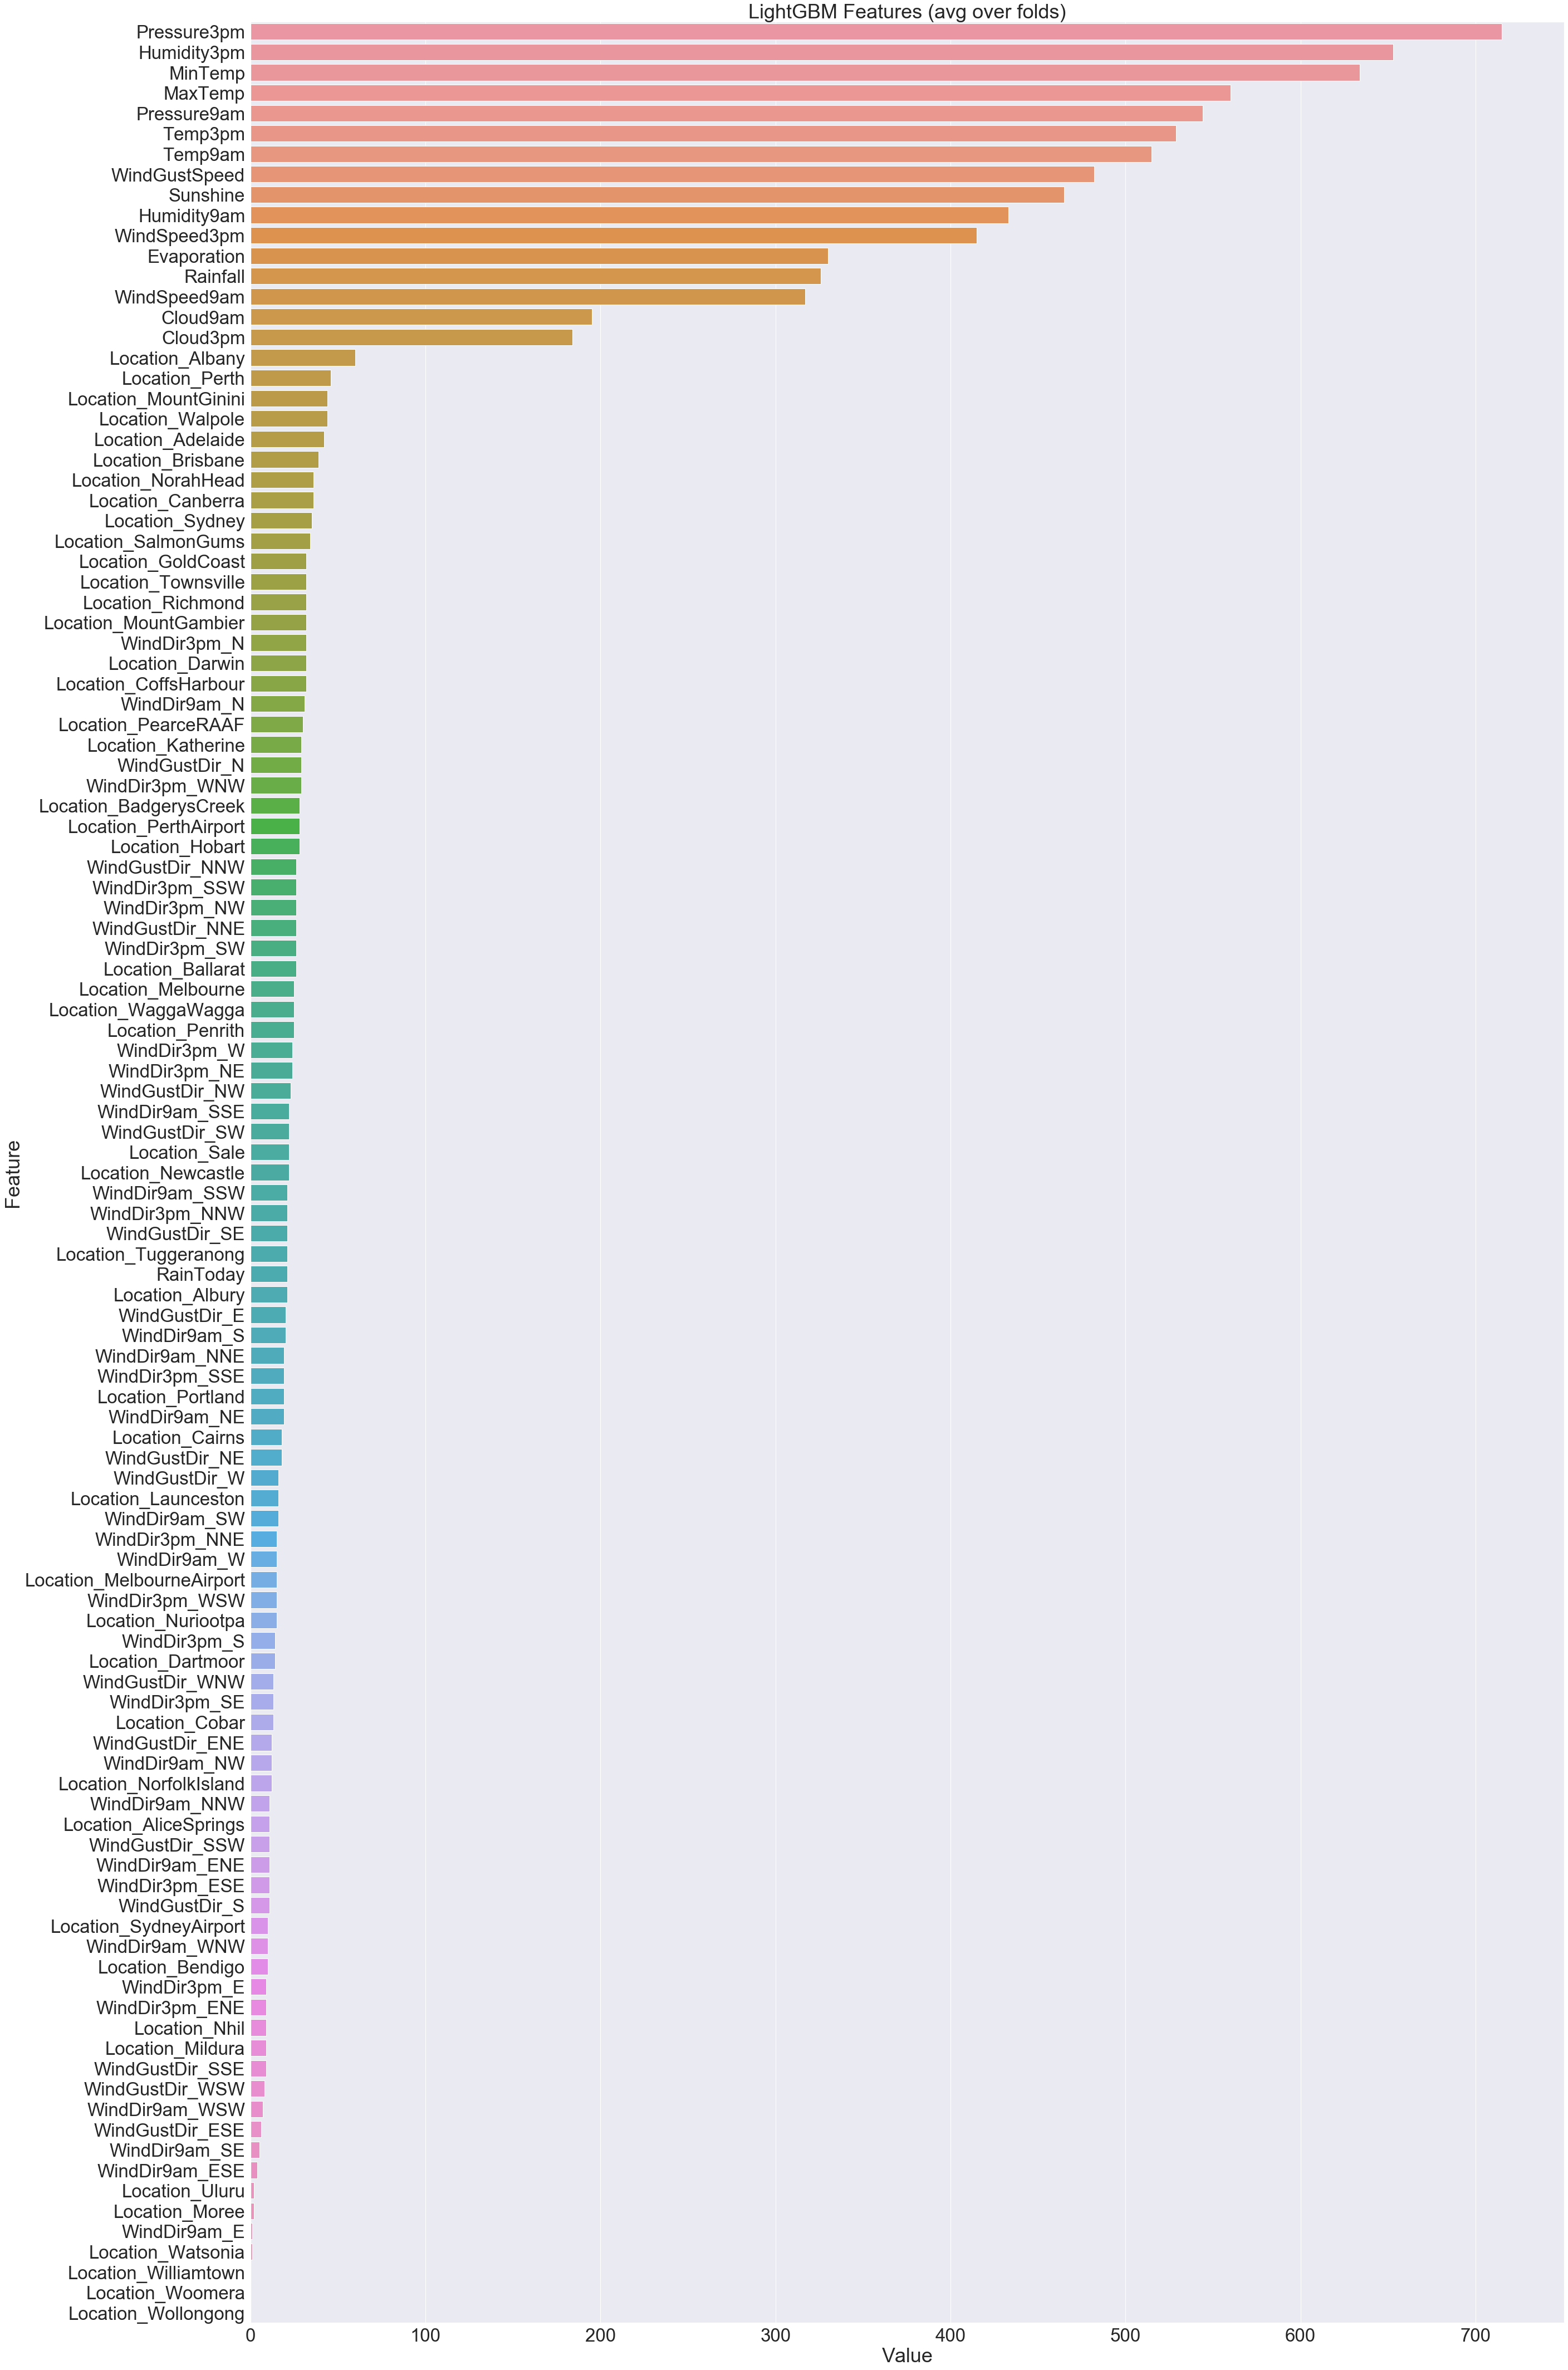

In [213]:
plotImp(clf_final, num = -1)

From the above, we see that today's rainfall is not necessarily the most important contributor to the model in terms of accuracy. This may go to show that just because it rained today, we should not rely on extrapolating the amount of rain today to forecast rain tomorrow.

Instead, what becomes apparent is the parameters describing atmospheric conditions are key to forecast rain tomorrow.

In addition, we could probably have done without the features for location or wind gust and directions.

In [229]:
feature_imp = pd.DataFrame({'Value':clf_final.feature_importances_,'Feature':feature_names})
feature_imp.sort_values(by="Value", ascending=False)[0:16]['Feature'].tolist()

['Pressure3pm',
 'Humidity3pm',
 'MinTemp',
 'MaxTemp',
 'Pressure9am',
 'Temp3pm',
 'Temp9am',
 'WindGustSpeed',
 'Sunshine',
 'Humidity9am',
 'WindSpeed3pm',
 'Evaporation',
 'Rainfall',
 'WindSpeed9am',
 'Cloud9am',
 'Cloud3pm']

In [232]:
model = sm.GLM.from_formula("RainTomorrow ~ Pressure3pm + Humidity3pm + MinTemp + MaxTemp + Pressure9am + Temp3pm + Temp9am + WindGustSpeed + Sunshine + Humidity9am + WindSpeed3pm + Evaporation + Rainfall + WindSpeed9am + Cloud9am + Cloud3pm", family=sm.families.Binomial(), data=df_raw)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           RainTomorrow   No. Observations:                58090
Model:                            GLM   Df Residuals:                    58073
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19412.
Date:                Sun, 26 Jan 2020   Deviance:                       38824.
Time:                        14:34:38   Pearson chi2:                 5.34e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        57.5429      2.402     23.959      0.000      52.836      62.250
Pressure3pm      -0.1872      0.008    -23.457      0.000      -0.203      -0.172
Humidity3pm       0.0556      0.002     33.847      0.000       0.052       0.059
MinTemp          -0.0377      0.007     -5.149      0.000      -0.052      -0.023
MaxTemp           0.0085      0.012      0.719      0.472      -0.015       0.032
Pressure9am       0.1238      0.008     15.639      0.000       0.108       0.139
Temp3pm          -0.0013      0.013     -0.097      0.923      -0.027       0.025
Temp9am           0.0403      0.011      3.709      0.000       0.019       0.062
WindGustSpeed     0.0609      0.002     39.019      0.000       0.058       0.064
Sunshine         -0.1425      0.006    -23.726      0.000      -0.154      -0.131
Humidity9am       0.0050      0.002      3.252      0.001       0.002       0.008
WindSpeed3pm     -0.0278      0.002    -12.882      0.000      -0.032      -0.024
Evaporation      -0.0136      0.006     -2.363      0.018      -0.025      -0.002
Rainfall          0.0242      0.002     12.380      0.000       0.020       0.028
WindSpeed9am     -0.0106      0.002     -5.194      0.000      -0.015      -0.007
Cloud9am         -0.0186      0.007     -2.533      0.011      -0.033      -0.004
Cloud3pm          0.1194      0.008     14.782      0.000       0.104       0.135
=================================================================================
"""

From the above, our GLM confirms that these features are important contributors to the model. Note however the large p-values for MaxTemp and Temp3pm. This could be because of multicollinearity with MinTemp and Temp9am.

In [233]:
dummy_df = pd.DataFrame(df_raw[['MaxTemp', 'Temp3pm', 'MinTemp', 'Temp9am']])
dummy_df_cor = dummy_df.corr()
pd.DataFrame(np.linalg.inv(dummy_df.corr().values), index = dummy_df_cor.index, columns=dummy_df_cor.columns)

,MaxTemp,Temp3pm,MinTemp,Temp9am
MaxTemp,41.127326,-34.672393,1.540755,-8.032074
Temp3pm,-34.672393,33.481902,0.231268,1.732892
MinTemp,1.540755,0.231268,5.963703,-6.943847
Temp9am,-8.032074,1.732892,-6.943847,12.895379


The diagonal values indicate the variance inflation factor (VIF) which is a metric for multicollinearity between two predictors. Values below 5 indicate that is collinearity is absent. 

From the above, we see these features experience multicollinearity. As such, the signifance of these features are invalid as the estimates of standard errors are underestimated.